In [1]:
import sys,os
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import pickle
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad(open("/nfs/team283/aa16/KR_NAS/data/CR_cells_19pcw+14pcw_AnnData_1.h5ad", "rb"))
adata.var_names = adata.var['SYMBOL']
adata.obs['Pool'].loc[adata.obs['Pool'] == 'CRcellsB'] = 'CRcells'
adata = adata[adata.obs['Pool'] == 'CRcells',:]
adata = adata[adata.obs['Age'] == '14 pcw',:]

In [11]:
DE_results = pd.read_pickle(open("/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cells_14pcw_pairwiseDE_cc.p", "rb" ))

In [12]:
DE_results = DE_results['Foetal brain (frontal lobe)_vs_Foetal brain (occipital lobe)']

In [8]:
subset = [np.abs(DE_results['log2fc'].iloc[i]) > 2.3 and DE_results['qval'].iloc[i] < 0.1 for i in range(len(DE_results['log2fc']))]

In [18]:
DE_results

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,log2_mean_Foetal brain (frontal lobe),log2_mean_Foetal brain (occipital lobe),log2_fold_change
11552,PDE4DIP,0.000026,0.137316,-1.111679,710.180344,False,False,9.923353,8.811675,1.111678
10575,NSMF,0.000031,0.137316,-0.792864,342.769493,False,False,8.763732,7.970868,0.792864
3108,CLDN11,0.000032,0.137316,3.922824,47.311958,False,False,2.549191,6.472014,-3.922824
231,ACVR2A,0.000037,0.137316,-1.686535,195.969772,False,False,8.224180,6.537645,1.686535
17982,ZCCHC24,0.000037,0.137316,1.711230,173.261192,False,False,6.341083,8.052313,-1.711230
...,...,...,...,...,...,...,...,...,...,...
6106,GINS3,1.000000,1.000000,0.446918,12.501761,False,False,3.403363,3.850281,-0.446918
15699,SYTL1,1.000000,1.000000,0.394807,7.134020,False,False,2.623848,3.018656,-0.394807
306,ADCY7,1.000000,1.000000,0.117429,9.193988,False,False,3.140782,3.258211,-0.117429
3144,CLEC2A,1.000000,1.000000,0.341656,7.449522,False,False,2.716229,3.057886,-0.341656


In [60]:
subset = [DE_results['qval'].iloc[i] < 0.25 and np.abs(DE_results['log2fc'].iloc[i]) > 1.5
and np.any(np.array([DE_results['log2_mean_Foetal brain (frontal lobe)'].iloc[i], DE_results['log2_mean_Foetal brain (occipital lobe)'].iloc[i]]) > 5) for i in range(len(DE_results['qval']))]

In [61]:
genesOfInterest = np.concatenate([np.array(('RELN', 'NR2F1', 'WNT7B')), np.array(DE_results.loc[subset,:]['gene'])])
genesOfInterest

array(['RELN', 'NR2F1', 'WNT7B', 'CLDN11', 'ACVR2A', 'ZCCHC24', 'CERK',
       'KCNJ9', 'SARNP', 'CSRP2', 'SLIT1', 'KLHL8', 'FBLL1', 'PSMC5',
       'KIF2A', 'SQLE', 'SEC16A', 'ANKRD50', 'CHORDC1', 'SUPT20H',
       'ERBB4', 'THBS3', 'SAMD4A', 'CCSER2'], dtype=object)

In [62]:
adata.obs['Tissue'].value_counts()

Frontal      16
Occipital    16
Name: Tissue, dtype: int64

In [63]:
adata.obs['Tissue'] = adata.obs['Tissue'].astype(str)
adata.obs['Tissue'].loc[adata.obs['Tissue'] == 'Foetal brain (occipital lobe)'] = 'Occipital'
adata.obs['Tissue'].loc[adata.obs['Tissue'] == 'Foetal brain (frontal lobe)'] = 'Frontal'

Trying to set attribute `.obs` of view, copying.
/nfs/team283/aa16/software/miniconda3/envs/ts21/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [64]:
adata = adata[[adata.obs['Tissue'].iloc[i] in ('Occipital', 'Frontal') for i in range(len(adata.obs['Tissue']))],:]

In [65]:
geneNames = adata.var_names[[g in genesOfInterest for g in adata.var_names]]
counts_cpm = adata.layers['X_corrected_cc_cpm'][:,[g in genesOfInterest for g in adata.var_names]]
regions  = adata.obs['Tissue']

In [66]:
tab = pd.DataFrame(index = range(np.prod(np.shape(counts_cpm))), columns = ('gene', 'counts', 'Region'))
n_genes = np.shape(counts_cpm)[1]
n_samples = np.shape(counts_cpm)[0]
for i in range(len(geneNames)):
    tab.iloc[(i*n_samples):((i+1)*n_samples),0] = geneNames[i]
    tab.iloc[(i*n_samples):((i+1)*n_samples),1] = counts_cpm[:,i] + 5
    tab.iloc[(i*n_samples):((i+1)*n_samples),2] = regions

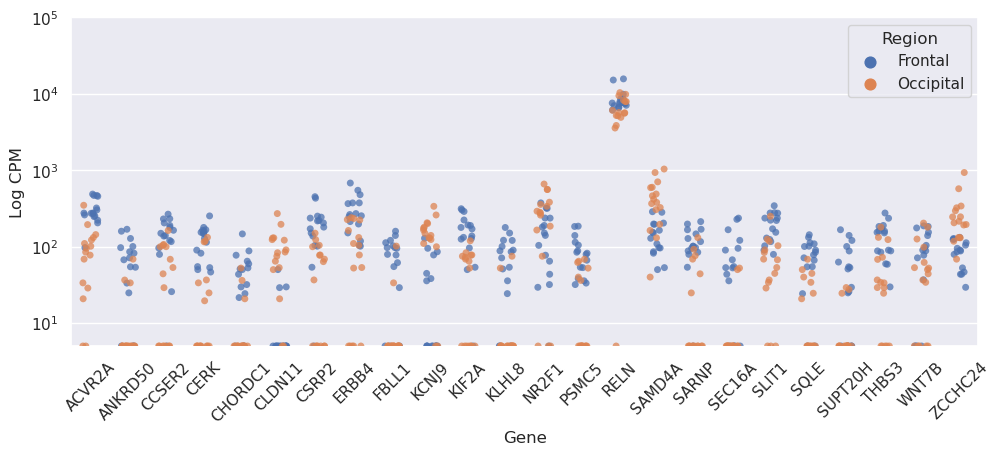

In [67]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,4.27)})
sns.stripplot(x="gene", y="counts", hue="Region", data=tab, alpha = 0.75, jitter=0.2)
plt.yscale('log')
plt.ylabel('Log CPM')
plt.xlabel('Gene')
plt.ylim(5, 10**5)
plt.xticks(rotation=45)
plt.show()

In [68]:
# Also look up their expression in 19pcw data:
adata = sc.read_h5ad(open("/nfs/team283/aa16/KR_NAS/data/CR_cells_AnnData_1.h5ad", "rb"))
adata.var_names = adata.var['SYMBOL']
adata = adata[adata.obs['Pool'] == 'CRcells',:]

Trying to set attribute `.obs` of view, copying.
/nfs/team283/aa16/software/miniconda3/envs/ts21/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


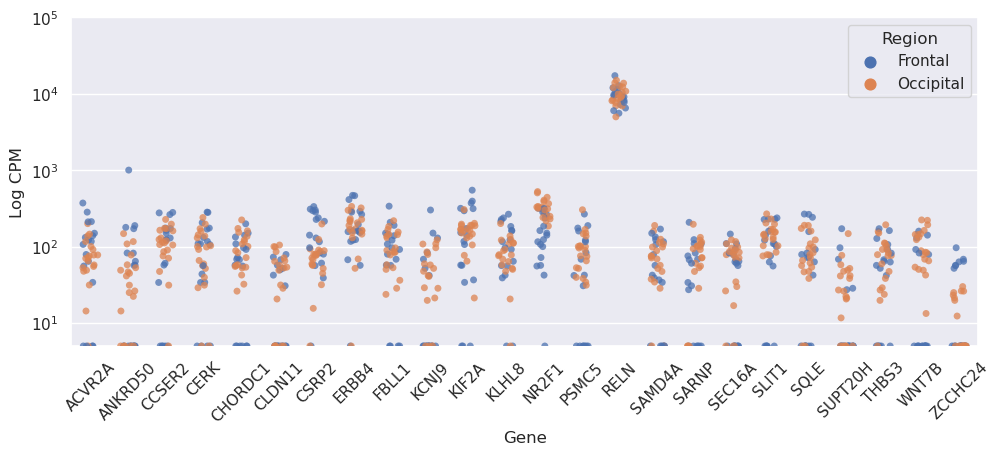

In [69]:
adata.obs['Tissue'] = adata.obs['Tissue'].astype(str)
adata.obs['Tissue'].loc[adata.obs['Tissue'] == 'Foetal brain (occipital lobe)'] = 'Occipital'
adata.obs['Tissue'].loc[adata.obs['Tissue'] == 'Foetal brain (frontal lobe)'] = 'Frontal'
adata = adata[[adata.obs['Tissue'].iloc[i] in ('Occipital', 'Frontal') for i in range(len(adata.obs['Tissue']))],:]
geneNames = adata.var_names[[g in genesOfInterest for g in adata.var_names]]
counts_cpm = adata.layers['X_corrected_cc_cpm'][:,[g in genesOfInterest for g in adata.var_names]]
regions  = adata.obs['Tissue']
tab = pd.DataFrame(index = range(np.prod(np.shape(counts_cpm))), columns = ('gene', 'counts', 'Region'))
n_genes = np.shape(counts_cpm)[1]
n_samples = np.shape(counts_cpm)[0]
for i in range(len(geneNames)):
    tab.iloc[(i*n_samples):((i+1)*n_samples),0] = geneNames[i]
    tab.iloc[(i*n_samples):((i+1)*n_samples),1] = counts_cpm[:,i] + 5
    tab.iloc[(i*n_samples):((i+1)*n_samples),2] = regions
    import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,4.27)})
sns.stripplot(x="gene", y="counts", hue="Region", data=tab, alpha = 0.75, jitter=0.2)
plt.yscale('log')
plt.ylabel('Log CPM')
plt.xlabel('Gene')
plt.ylim(5, 10**5)
plt.xticks(rotation=45)
plt.show()